In [1]:
import sys
# Change to wherever you've copied the repo.
sys.path.insert(1, '/home/richard/nfmc_jax/')
import nfmc_jax
import arviz as az
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import scipy
from sklearn.neighbors import KernelDensity
import jax
import jax.numpy as jnp
from jax.scipy.special import logsumexp
from jax.scipy.stats import multivariate_normal as mvn
from scipy.stats import multivariate_normal as n_mvn
import chaospy
import corner
import torch
import warnings
import pickle

import getdist
from getdist import plots, MCSamples

seed=1234
np.random.seed(seed)
key = jax.random.PRNGKey(seed)

ModuleNotFoundError: No module named 'nfmc_jax'

# Sampling a 100-d noisy funnel

In [2]:
D = 100 # Latent variable dimensions (not NF latent space)
a = 3.
b = 0.5

#theta_sample = a * jax.random.normal(jax.random.PRNGKey(0))
#print(theta_sample)
theta_sample = 0
z_sample = jax.random.normal(jax.random.PRNGKey(0), shape=(D,))
z_sample = z_sample * jnp.exp(b * theta_sample)
data_sample = jax.random.multivariate_normal(jax.random.PRNGKey(0), mean=z_sample, 
                                             cov=0.1**2*jnp.eye(D))

def log_like(x, data=data_sample):
    theta = x[0]
    z = x[1:]
    return jax.scipy.stats.multivariate_normal.logpdf(z, mean=data, cov=0.1**2*jnp.eye(len(z)))

def log_prior(x):
    theta = x[0]
    z = x[1:]
    log_pi_theta = jax.scipy.stats.norm.logpdf(theta, loc=0, scale=a)
    log_pi_z = jnp.sum(jax.scipy.stats.norm.logpdf(z, loc=0, scale=jnp.exp(b * theta)))
    return log_pi_theta + log_pi_z

def prior_rvs(key, N):
    n01 = jax.random.normal(key, shape=(N, D + 1))
    theta = n01[:, 0] * a
    z = jax.vmap(lambda x1, x2: x1 * jnp.exp(x2 * b))(n01[:, 1:], theta)
    x = jnp.concatenate([theta.reshape(N, 1), z], axis=1)
    return x

log_like_grad = jax.grad(log_like)
log_prior_grad = jax.grad(log_prior)

n01_init = jax.random.normal(jax.random.PRNGKey(0), shape=(20, D + 1))
theta_init = n01_init[:, 0] * a
z_init = jax.vmap(lambda x1, x2: x1 * jnp.exp(x2 * b))(n01_init[:, 1:], theta_init)
x_init = jnp.concatenate([theta_init.reshape(20, 1), z_init], axis=1)
print(jnp.shape(x_init))

(20, 101)


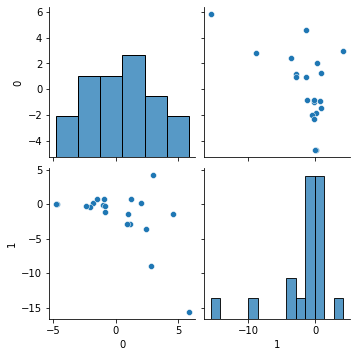

In [3]:
xdf = x_init[:, 0:2]
df = pd.DataFrame(xdf)
sns.pairplot(df)

In [4]:
truth_df = pd.read_csv('./fiducial_samples/noisy_funnel_100zD_sigma0p1.csv', index_col=0)

truth_x = np.empty((2000, D + 1))
truth_x[:, 0] = truth_df["('posterior', 'theta')"]
for i in range(D):
    truth_x[:, i + 1] = truth_df["('posterior', 'z[{0}]', {1})".format(i, i)]
    
#truth_x = truth_x[0::100, :]
print(np.shape(truth_x))
np.savetxt('./fiducial_samples/noise_funnel_100d_samples_sigma0p1.txt', truth_x)

(2000, 101)


<AxesSubplot:ylabel='Density'>

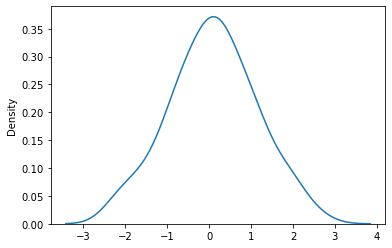

In [5]:
sns.kdeplot(data_sample)

<AxesSubplot:ylabel='Density'>

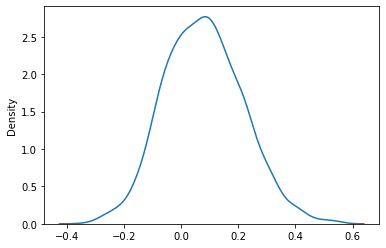

In [6]:
sns.kdeplot(truth_x[:, 0])

Below I have defined the key parameters that I think you will need to worry about. If you look at the actual code you'll see a lot more parameters. Some of these are from older versions of the algorithm, and some of these are only relevant for the NFO optimization algorithm. We'll tidy this up at some point, but this should be enough to get you going.

In [38]:
'''
General parameters
'''
log_like_args = (data_sample,)
log_prior_args = () 
vmap = True
parallel_backend = None
bounds = None
random_seed = seed

'''
SINF/SNF parameters
---------------
'''
#sinf parameters
reg_alpha = (0.98, 0.98)
NBfirstlayer = True
verbose = False
interp_nbin = 20
sgd_steps = 0
gamma = 0
knots_trainable = 20
optimize_directions = None
logp_cut = None
edge_bins = 0
Whiten = True
Whiten_with_weights = True
Whiten_reg = 0.
iteration = 20
NERCOME = True
t_ess = 0.5
MSWD_max_iter = None

frac_validate = 0.2
snf_loss = 3
reg = 0.0
reg1 = 0.98
reg2 = 0.98

dla_step_size = 1.0
num_extra_dla_samples = 81
grad_norm_thresh = 0.5
max_dla_line_steps = 5
log_like_grad = log_like_grad
log_prior_grad = log_prior_grad
accelerate_dla = False
dla_beta_thresh = 0.5
latent_dla = True
maxknot = False
max_dla_burnin = 100

max_dla_iter = 16

flow_type = 'SINF'
maf_layers = 10
maf_hidden = 5
maf_activation = torch.sigmoid
dropout_prob = 0.2
maf_epochs = 200

mala_step_size = 1e-3
num_mala = 1
tune_mala = 5

Now we can run our 10d Gaussian example.

In [39]:
trace = nfmc_jax.infer_dlmc(log_like_func=log_like, 
                             log_prior_func=log_prior,
                             init_samples=x_init,
                             log_like_args=log_like_args,
                             log_prior_args=log_prior_args,
                             vmap=vmap, 
                             parallel_backend=parallel_backend, 
                             bounds=bounds,
                             #sinf parameters
                             reg_alpha=reg_alpha,
                             NBfirstlayer=NBfirstlayer, 
                             verbose=verbose,
                             interp_nbin=interp_nbin,
                             iteration=iteration,
                             sgd_steps=sgd_steps,
                             gamma=gamma,
                             knots_trainable=knots_trainable,
                             optimize_directions=optimize_directions,
                             logp_cut=logp_cut,
                             random_seed=seed,
                             edge_bins=edge_bins,
                             Whiten=Whiten,
                             Whiten_with_weights=Whiten_with_weights,
                             frac_validate=frac_validate,
                             snf_loss=snf_loss,
                             reg=reg,
                             reg1=reg1,
                             reg2=reg2,
                             t_ess=t_ess,
                             NERCOME=NERCOME,
                             dla_step_size=dla_step_size,
                             num_extra_dla_samples=num_extra_dla_samples,
                             grad_norm_thresh=grad_norm_thresh,
                             log_like_grad=log_like_grad,
                             log_prior_grad=log_prior_grad,
                             max_dla_line_steps=max_dla_line_steps,
                             accelerate_dla=accelerate_dla,
                             latent_dla=latent_dla,
                             max_dla_iter=max_dla_iter,
                             flow_type=flow_type,
                             maf_layers=maf_layers,
                             maf_hidden=maf_hidden,
                             maf_activation=maf_activation,
                             dropout_prob=dropout_prob,
                             maf_epochs=maf_epochs,
                             mala_step_size=mala_step_size,
                             num_mala=num_mala,
                             tune_mala=tune_mala,
                             maxknot=maxknot,
                             MSWD_max_iter=MSWD_max_iter,
                             Whiten_reg=Whiten_reg,
                             max_dla_burnin=max_dla_burnin)

Time for prior DLA = 0.22393583399997397
Current logZ estimate = -1177.3072509765625
Acceptance rate for MH adjustment: 0.1
Time for DLA MH adjustment = 0.20815928799999028
Time for latent space DLA = 1.166051087000028
Current logZ estimate = -1138.398193359375
Burnin stage 1, Fisher Divergence: 57801612.0
Burnin stage 1, abs(norm(dlogq)/norm(dlogp)) = 0.008760700933635235
Acceptance rate for MH adjustment: 0.35
Time for DLA MH adjustment = 0.17926819299998442
Time for latent space DLA = 0.3616349799999625
Current logZ estimate = -1036.0611572265625
Burnin stage 2, Fisher Divergence: 1149209.25
Burnin stage 2, abs(norm(dlogq)/norm(dlogp)) = 0.007477111183106899
Acceptance rate for MH adjustment: 0.3
Time for DLA MH adjustment = 0.14871622199996182
Time for latent space DLA = 0.5345867069999599
Current logZ estimate = -990.1315307617188
Burnin stage 3, Fisher Divergence: 400464.1875
Burnin stage 3, abs(norm(dlogq)/norm(dlogp)) = 0.011831806041300297
Acceptance rate for MH adjustment: 0.

Time for latent space DLA = 0.371422315000018
Current logZ estimate = -216.51461791992188
Burnin stage 28, Fisher Divergence: 530.077392578125
Burnin stage 28, abs(norm(dlogq)/norm(dlogp)) = 0.26153838634490967
Acceptance rate for MH adjustment: 0.55
Time for DLA MH adjustment = 0.13939630200002284
Time for latent space DLA = 0.3627844690000188
Current logZ estimate = -206.03790283203125
Burnin stage 29, Fisher Divergence: 438.33758544921875
Burnin stage 29, abs(norm(dlogq)/norm(dlogp)) = 0.2724331319332123
Acceptance rate for MH adjustment: 0.55
Time for DLA MH adjustment = 0.18385459000000992
Time for latent space DLA = 0.363679803000025
Current logZ estimate = -187.8192138671875
Burnin stage 30, Fisher Divergence: 397.9884338378906
Burnin stage 30, abs(norm(dlogq)/norm(dlogp)) = 0.29958996176719666
Acceptance rate for MH adjustment: 0.6
Time for DLA MH adjustment = 0.1337688869999738
Time for latent space DLA = 0.3687475460000087
Current logZ estimate = -177.3533935546875
Burnin sta

Acceptance rate for MH adjustment: 0.7524752475247525
Time for DLA MH adjustment = 0.28129162199996927
Time for latent space DLA = 0.7990055170000119
Stage 13, Sample Mean: 0.08784431964159012
Stage 13, Sample Variance: 1.0359023809432983
Current logZ estimate = -147.40843200683594
DLA stage 13, Latent Fisher Divergence: 4.925093173980713
Primary DLA stage 13, abs[(Z(i+1) - Z(i)) / Z(i)] = 0.0923711434006691
Acceptance rate for MH adjustment: 0.6732673267326733
Time for DLA MH adjustment = 0.25218585299995766
Time for latent space DLA = 0.8008014380000077
Stage 14, Sample Mean: 0.08889114856719971
Stage 14, Sample Variance: 1.0403825044631958
Current logZ estimate = -147.8643035888672
DLA stage 14, Latent Fisher Divergence: 3.98095703125
Primary DLA stage 14, abs[(Z(i+1) - Z(i)) / Z(i)] = 0.13583415746688843
Acceptance rate for MH adjustment: 0.7821782178217822
Time for DLA MH adjustment = 0.31631716200001847
Time for latent space DLA = 0.9518314909999503
Stage 15, Sample Mean: 0.08828

100%|██████████| 6/6 [00:03<00:00,  1.53it/s]

Mean MALA acceptance rate = 0.9900990128517151
Dual averaged step size = [[0.0004852 ]
 [0.00049874]
 [0.00050981]
 [0.00047154]
 [0.00051497]
 [0.00053213]
 [0.00049956]
 [0.00048468]
 [0.00050062]
 [0.00050284]
 [0.00052421]
 [0.00051124]
 [0.00052175]
 [0.00051496]
 [0.00052407]
 [0.00049387]
 [0.00051288]
 [0.00050441]
 [0.00050206]
 [0.00055703]
 [0.00052154]
 [0.00052817]
 [0.00051607]
 [0.00054396]
 [0.00053937]
 [0.00050569]
 [0.00052221]
 [0.00050337]
 [0.00050607]
 [0.00050907]
 [0.00052717]
 [0.00053897]
 [0.00051986]
 [0.00049537]
 [0.00055687]
 [0.00053124]
 [0.00051281]
 [0.00055098]
 [0.00052599]
 [0.00054209]
 [0.00049794]
 [0.00051742]
 [0.00052469]
 [0.00054647]
 [0.00051858]
 [0.00052836]
 [0.0005129 ]
 [0.0005163 ]
 [0.00052976]
 [0.00053624]
 [0.00225677]
 [0.00054477]
 [0.0005725 ]
 [0.00052683]
 [0.00052101]
 [0.00055621]
 [0.00051041]
 [0.00052899]
 [0.00054802]
 [0.00120013]
 [0.00052895]
 [0.00056166]
 [0.00054195]
 [0.00066823]
 [0.00052435]
 [0.00057111]
 [0

In [40]:
'''
f = open('./paper_experiments/funnel_100d_sigma0p1_trace.pkl', 'wb')
pickle.dump(trace, f)
f.close()
'''

"\nf = open('./paper_experiments/funnel_100d_sigma0p1_trace.pkl', 'wb')\npickle.dump(trace, f)\nf.close()\n"

The output from sampling is stored in the trace object. This is currently a collection of dictionaries containing a lot of output stats and samples for development/debugging purposes.

In [41]:
44.93142318725586# Check the dictionary keys.SINF
trace.keys()

dict_keys(['final_q_samples', 'final_qw_weights', 'log_evidence', 'mh_samples', 'dla_samples', 'mh_logp', 'mh_logq', 'mh_dlogp', 'mh_dlogq', 'dla_logZ', 'dla_q_models', 'dla_qw_models'])

In [42]:
# To inspect the sampling output, we can pull out the q_models.
q_models = trace['dla_q_models'][0]
q_models.keys()
#print(len(q_models.keys()))

dict_keys(['init_0', 'burnin_0', 'burnin_1', 'burnin_2', 'burnin_3', 'burnin_4', 'burnin_5', 'burnin_6', 'burnin_7', 'burnin_8', 'burnin_9', 'burnin_10', 'burnin_11', 'burnin_12', 'burnin_13', 'burnin_14', 'burnin_15', 'burnin_16', 'burnin_17', 'burnin_18', 'burnin_19', 'burnin_20', 'burnin_21', 'burnin_22', 'burnin_23', 'burnin_24', 'burnin_25', 'burnin_26', 'burnin_27', 'burnin_28', 'burnin_29', 'burnin_30', 'burnin_31', 'burnin_32', 'burnin_33', 'burnin_34', 'burnin_35', 'burnin_36', 'burnin_37', 'burnin_38', 'post_burnin_0', 'DLA_1', 'DLA_2', 'DLA_3', 'DLA_4', 'DLA_5', 'DLA_6', 'DLA_7', 'DLA_8', 'DLA_9', 'DLA_10', 'DLA_11', 'DLA_12', 'DLA_13', 'DLA_14', 'DLA_15', 'DLA_16', 'DLA_17'])

# Plotting

In [43]:
def sns_pairplot(q_samples, q_weights, truth_samples=None, q_label='q', 
                 truth_label='Truth', out_name=None, levels=10, legend_bbox=None, 
                 prior=False, bw=0.3):
    
    q_samples = np.asarray(q_samples)
    q_weights = np.asarray(q_weights)
        
    labels = []
    
    if truth_samples is not None:
        
        if prior:
            
            truth_samples = np.ones_like(q_samples) * 30
        
        truth_samples = np.asarray(truth_samples)
        x_samples = np.concatenate([q_samples, truth_samples])
        weights = np.concatenate([q_weights, np.ones(len(truth_samples))])
    
        for i in range(len(q_samples)):
            labels.append(q_label)
        for i in range(len(truth_samples)):
            labels.append(truth_label)
    
    else:

        x_samples = q_samples
        weights = q_weights
        
        for i in range(len(q_samples)):
            labels.append(q_label)
    
    
    d = {}
    d['labels'] = labels
    for i in range(x_samples.shape[1]):
        if i == 0:
            d[r'$\theta$'] = x_samples[:, i]
        else:
            d[f'$z_{i}$'] = x_samples[:, i]
        
    df = pd.DataFrame(d)
    print(df)
    
    sns.set_theme()
    g = sns.PairGrid(df, hue='labels', palette='deep')
    g.map_diag(sns.kdeplot, weights=weights, common_norm=False, levels=levels, bw=bw)
    g.map_lower(sns.kdeplot, weights=weights, common_norm=False, levels=levels, bw=bw)
    g.map_upper(sns.kdeplot, weights=weights, common_norm=False, levels=levels, bw=bw)
    if legend_bbox is not None:
        g.add_legend(bbox_to_anchor=legend_bbox)
    if out_name is not None:
        g.savefig(out_name)

()


<Figure size 432x288 with 0 Axes>

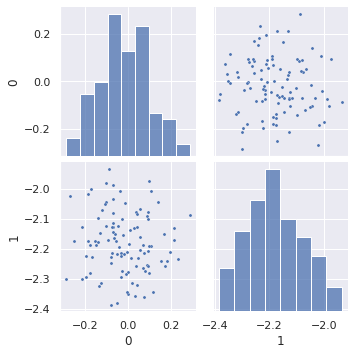

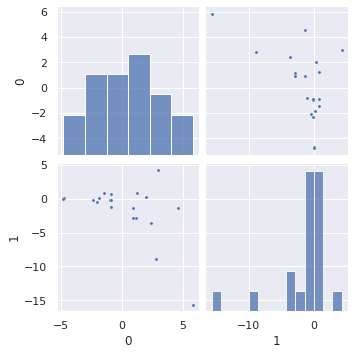

In [44]:
#mh_samples = trace['final_q_samples'][0]
mh_samples = trace['mh_samples'][0]
print(np.shape(mh_samples))
x = mh_samples['DLA_15'][:, 0:2]
plt.figure()
sns.pairplot(pd.DataFrame(x),
             plot_kws={'s': 10})
sns.pairplot(pd.DataFrame(x_init[:,0:2]), plot_kws={'s': 10})

     labels  $\theta$     $z_1$
0      DLMC  0.054467 -2.173152
1      DLMC  0.194862 -2.182581
2      DLMC  0.026217 -2.106822
3      DLMC -0.063561 -2.145526
4      DLMC  0.201390 -2.087396
...     ...       ...       ...
2096   NUTS -0.058458 -2.194374
2097   NUTS -0.058784 -2.057745
2098   NUTS -0.267428 -2.032796
2099   NUTS  0.444632 -2.286263
2100   NUTS -0.125063 -2.075453

[2101 rows x 3 columns]


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.6 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.6 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.6 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/

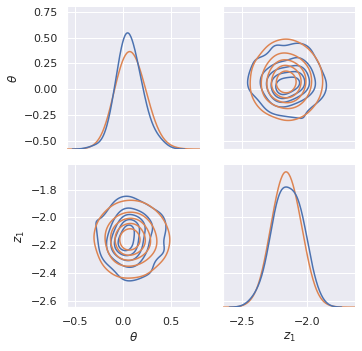

In [51]:
dla_key = 'DLA_17'
sns_pairplot(mh_samples[dla_key][:, 0:2], 
             np.ones(len(mh_samples['DLA_1'][:, 0:2])),
             truth_samples=truth_x[:, 0:2], levels=6, 
             q_label='DLMC', truth_label='NUTS', bw=0.6,
             out_name='./dla_figs/paper/funnel_100d_sigma0p1_DLA_17_101_samples.png')